# Customized Layer

Let's build a Tensorflow Keras layer in which a standard activation outputs from linear combinations of inputs with weights and biases (first output), is multiplied to a vector of weights called 'adapter' (second output).

This new vector may variate the importance of the first output towards the next layers

In [21]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, activations, losses
import pandas as pd
from matplotlib import pyplot as plt

Example data

In [2]:
m = 10000
p = 4
random_state = 117
X, y = make_regression(m , p, n_informative=3, n_targets=1, bias=1.0, random_state=random_state)

Setup the class layer with adapter. First, in the build() method, a new weight is setup and called the adapter. Lastly, in the call() method, the adapter weight is simply multiplied to the activation output.

In [32]:
class AdaptiveActivation(layers.Layer):
  def __init__ (self, units=32, input_dim=32):
    super(AdaptiveActivation, self).__init__()
    self.units = units
    self.adapter = None
  def build(self, input_shape):
    # Weights setup
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer="random_normal",
                             trainable=True,
                             name='weights',
                             )
    # Biases setup
    self.b = self.add_weight(shape=(self.units,),
                             initializer=tf.zeros_initializer(),
                             trainable=True,
                             name='bias',
                             )
    # Adapter setup
    self.adapter = self.add_weight(shape=(self.units,),
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True,
                                   name='adapters',
                                   )
  def call(self, inputs):
    output_linear = tf.matmul(inputs, self.w) + self.b
    return self.adapter * activations.relu(output_linear)

In [4]:
Çx = tf.ones((2, 2))
customActivation_layer = AdaptiveActivation(32)
out = customActivation_layer(x)

Define custom model

In [36]:
model_adaptive = keras.Sequential()
model_adaptive.add(keras.Input(shape=(p, )))
model_adaptive.add(AdaptiveActivation(16))
model_adaptive.add(layers.Dense(1, activation='linear'))

In [6]:
model_adaptive.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 adaptive_activation_1 (Adap  (None, 16)               96        
 tiveActivation)                                                 
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


Define base model for comparing

In [37]:
model_base = keras.Sequential()
model_base.add(keras.Input(shape=(p, )))
model_base.add(layers.Dense(16, activation='relu'))
model_base.add(layers.Dense(1, activation='linear'))

In [8]:
model_base.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16)                80        
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=random_state)

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((9000, 4), (9000,), (1000, 4), (1000,))

In [38]:
model_adaptive.compile(optimizer='rmsprop', loss=losses.mse, metrics=losses.mae)
model_base.compile(optimizer='rmsprop', loss=losses.mse, metrics=losses.mae)

In [13]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=10, verbose=0)

In [14]:
epochs = 100

In [33]:
import time

In [39]:
start_time = time.time()
h_adaptive = model_adaptive.fit(X_train, y_train,
                   epochs=epochs,
                   batch_size=64,
                   validation_split=0.1,
                   verbose=2,
                   callbacks=[callback]
                   )
print("time taken:", time.time() - start_time)

Epoch 1/100
127/127 - 1s - loss: 16628.6426 - mean_absolute_error: 103.0602 - val_loss: 16131.6592 - val_mean_absolute_error: 100.9653 - 718ms/epoch - 6ms/step
Epoch 2/100
127/127 - 0s - loss: 16508.0137 - mean_absolute_error: 102.6542 - val_loss: 15940.2666 - val_mean_absolute_error: 100.3137 - 193ms/epoch - 2ms/step
Epoch 3/100
127/127 - 0s - loss: 16224.1055 - mean_absolute_error: 101.7003 - val_loss: 15566.4863 - val_mean_absolute_error: 99.0312 - 193ms/epoch - 2ms/step
Epoch 4/100
127/127 - 0s - loss: 15731.7197 - mean_absolute_error: 100.0326 - val_loss: 14966.5010 - val_mean_absolute_error: 96.9384 - 239ms/epoch - 2ms/step
Epoch 5/100
127/127 - 0s - loss: 15010.9053 - mean_absolute_error: 97.5115 - val_loss: 14114.7871 - val_mean_absolute_error: 93.8888 - 191ms/epoch - 2ms/step
Epoch 6/100
127/127 - 0s - loss: 14002.2197 - mean_absolute_error: 93.9012 - val_loss: 12977.7725 - val_mean_absolute_error: 89.6764 - 247ms/epoch - 2ms/step
Epoch 7/100
127/127 - 0s - loss: 12724.9600 - 

In [40]:
start_time = time.time()
h_base = model_base.fit(X_train, y_train,
               epochs=epochs,
               batch_size=64,
               validation_split=0.1,
               verbose=2,
               callbacks=[callback]
               )
print("time taken:", time.time() - start_time)

Epoch 1/100
127/127 - 1s - loss: 16539.3574 - mean_absolute_error: 102.7830 - val_loss: 15967.5078 - val_mean_absolute_error: 100.4569 - 706ms/epoch - 6ms/step
Epoch 2/100
127/127 - 0s - loss: 16283.1807 - mean_absolute_error: 101.9648 - val_loss: 15657.6514 - val_mean_absolute_error: 99.4347 - 218ms/epoch - 2ms/step
Epoch 3/100
127/127 - 0s - loss: 15903.4258 - mean_absolute_error: 100.7081 - val_loss: 15207.2998 - val_mean_absolute_error: 97.9089 - 283ms/epoch - 2ms/step
Epoch 4/100
127/127 - 0s - loss: 15386.4385 - mean_absolute_error: 98.9467 - val_loss: 14625.2578 - val_mean_absolute_error: 95.8822 - 332ms/epoch - 3ms/step
Epoch 5/100
127/127 - 0s - loss: 14733.8359 - mean_absolute_error: 96.6820 - val_loss: 13921.6348 - val_mean_absolute_error: 93.3634 - 297ms/epoch - 2ms/step
Epoch 6/100
127/127 - 0s - loss: 13969.0420 - mean_absolute_error: 93.9435 - val_loss: 13111.0381 - val_mean_absolute_error: 90.3706 - 337ms/epoch - 3ms/step
Epoch 7/100
127/127 - 0s - loss: 13101.4805 - me

In [17]:
model_base.evaluate(X_test, y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.2681 - mean_absolute_error: 0.2265


[0.26812639832496643, 0.22645775973796844]

In [18]:
model_adaptive.evaluate(X_test, y_test)

32/32 [==============================] - 0s 1ms/step - loss: 0.0298 - mean_absolute_error: 0.0867


[0.029812728986144066, 0.08668028563261032]

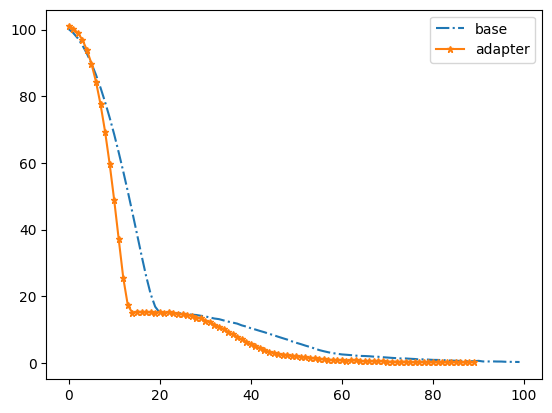

In [31]:
plt.plot(h_base.history["val_mean_absolute_error"],
         "-.",
         markersize=5,
         label="base"
         )
plt.plot(h_adaptive.history["val_mean_absolute_error"],
         "-*",
         markersize=5,
         label="adapter")
plt.legend()

From the plot, the model with adapter layer reaches a plateau in less epochs than a model with no adapter, i.e. adapter may help in training, but the loss plateau values are fairly the same in both lines.

Check values of adapter parameter

In [ ]:
model_adaptive.weights[2]

<tf.Variable 'adaptive_activation_1/adapters:0' shape=(16,) dtype=float32, numpy=
array([ 0.72844213, -0.7390092 , -0.6723192 , -0.42875537,  0.31873676,
       -0.531977  , -0.39968258,  0.07008532, -0.5568499 , -0.38792995,
       -0.36615428, -0.0129946 , -0.37562716, -0.3111375 ,  1.3562351 ,
       -0.05103129], dtype=float32)>

In [ ]:
adapters_data = model_adaptive.weights[2].numpy()

In [ ]:
df_adapters = pd.Series(adapters_data, name='Adapters')

In [ ]:
df_adapters.describe()

count    16.000000
mean     -0.571527
std       2.001562
min      -2.575184
25%      -2.242739
50%      -1.705827
75%       1.134458
max       2.660141
Name: Adapters, dtype: float64

<Axes: ylabel='Frequency'>

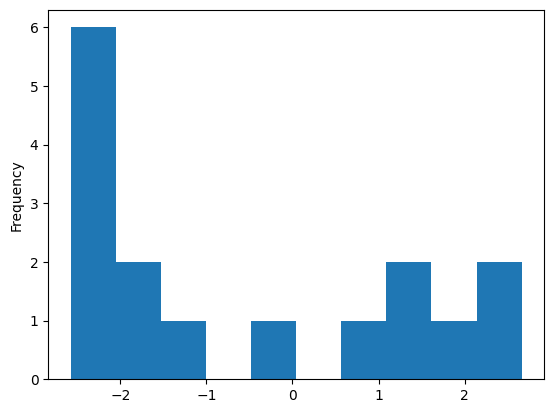

In [ ]:
df_adapters.plot(kind='hist')

We can try the same with a CNN model, i.e. a neural network specialized in
analyzing and making predictions from images

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
class AdaptiveActivationCNN(layers.Layer):
  def __init__ (self, units=32, input_dim=32):
    super(AdaptiveActivation, self).__init__()
    self.units = units
    self.adapter = None
  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer="random_normal",
                             trainable=True,
                             name='weights',
                             )
    # Weights setup
    #w_init = tf.random_normal_initializer()
    #self.w = tf.Variable(
    #    initial_value=w_init(shape=(input_dim, units), dtype="float32"),
    #    trainable=True
    #    )
    # Bias setup
    #b_init = tf.zeros_initializer()
    #self.b = tf.Variable(
    #    initial_value=b_init(shape=(self.units, ), dtype="float32"), trainable=True
    #    )
    self.b = self.add_weight(shape=(self.units,),
                             initializer=tf.zeros_initializer(),
                             trainable=True,
                             name='bias',
                             )
    # Adapter setup
    #adapter_init = tf.random_normal_initializer()
    #self.adapter = tf.Variable(
    #    initial_value=adapter_init(shape=(self.units, ), dtype="float32"),
    #    trainable=True,
    #)
    self.adapter = self.add_weight(shape=(self.units,),
                                   initializer=tf.random_normal_initializer(),
                                   trainable=True,
                                   name='adapters',
                                   )

  def call(self, inputs):
    output_linear = tf.matmul(inputs, self.w) + self.b
    return self.adapter * activations.relu(output_linear)